# For M=2,N=2,K=3   24 dimension

In [1]:
%cd /Users/user/Desktop/IWF-DNN/data2DComplex
%pwd
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import print_function
import scipy.io as sio
import time
from sklearn.cross_validation import train_test_split
%matplotlib inline

/Users/user/Desktop/IWF-DNN/data2DComplex


/Users/user/anaconda2/envs/haha/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Training data

In [2]:
DateLocation='MIMO50000_3.mat'
Data = sio.loadmat(DateLocation)#load data
Xdata=Data['X']
Ydata=Data['Y']
Xdata = np.transpose(Xdata)
Ydata = np.transpose(Ydata)
X = np.column_stack((np.real(Xdata), np.imag(Xdata)))
Y = np.column_stack((np.real(Ydata), np.imag(Ydata)))
x_train, x_val ,y_train, y_val= train_test_split(X, Y, test_size=0.3)

In [3]:
DateLocation='MIMO5000_3.mat'
DataTest10000 = sio.loadmat(DateLocation)#load data
Xtest=DataTest10000['X']
Xtest = np.transpose(Xtest)
Ytest=DataTest10000['Y']
Ytest = np.transpose(Ytest)
Xtest = np.column_stack((np.real(Xtest), np.imag(Xtest)))
Ytest = np.column_stack((np.real(Ytest), np.imag(Ytest)))

# Preprocessing Standard

In [4]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(x_train)  
x_train_standard = scaler.transform(x_train)  
x_val_standard = scaler.transform(x_val)  
Xtest_standard = scaler.transform(Xtest)  

# Preprocess autoencoder

In [5]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 10  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
input_dim=24
# this is our input placeholder
input_img = Input(shape=(input_dim,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_dim, activation='relu')(encoded)

# #this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# #a separate encoder model
encoder = Model(input_img, encoded)
##a separate decoder model
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=50,
                shuffle=True,
                validation_data=(x_val, x_val))

Using TensorFlow backend.


Train on 35000 samples, validate on 15000 samples
Epoch 1/30
35000/35000 [==============================] - 2s 59us/step - loss: 0.1303 - val_loss: -0.0202
Epoch 2/30
35000/35000 [==============================] - 2s 56us/step - loss: -0.1322 - val_loss: -0.2389
Epoch 3/30
35000/35000 [==============================] - 2s 56us/step - loss: -0.3325 - val_loss: -0.4126
Epoch 4/30
35000/35000 [==============================] - 2s 68us/step - loss: -0.4845 - val_loss: -0.5537
Epoch 5/30
35000/35000 [==============================] - 2s 63us/step - loss: -0.6240 - val_loss: -0.6883
Epoch 6/30
35000/35000 [==============================] - 2s 68us/step - loss: -0.7414 - val_loss: -0.7950
Epoch 7/30
35000/35000 [==============================] - 2s 69us/step - loss: -0.8464 - val_loss: -0.8982
Epoch 8/30
35000/35000 [==============================] - 2s 64us/step - loss: -0.9546 - val_loss: -0.9977
Epoch 9/30
35000/35000 [==============================] - 2s 61us/step - loss: -1.0422 - val_lo

# sparsity add regularizer

In [44]:
# tensorboard --logdir=/tmp/autoencoder

from keras.layers import Input, Dense
from keras import regularizers
from keras.models import Model
from keras.callbacks import TensorBoard


# this is the size of our encoded representations
encoding_dim = 10  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
input_dim=24
# this is our input placeholder
input_img = Input(shape=(input_dim,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu',activity_regularizer=regularizers.l1(10e-5))(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_dim, activation='relu')(encoded)

# #this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# #a separate encoder model
encoder = Model(input_img, encoded)
##a separate decoder model
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
# autoencoder.fit(x_train, x_train,
#                 epochs=30,
#                 batch_size=50,
#                 shuffle=True,
#                 validation_data=(x_val, x_val))

In [45]:
hist = autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 35000 samples, validate on 15000 samples
Epoch 1/20
35000/35000 [==============================] - 1s 30us/step - loss: 0.6027 - val_loss: 0.4943
Epoch 2/20
35000/35000 [==============================] - 1s 27us/step - loss: 0.4463 - val_loss: 0.3793
Epoch 3/20
35000/35000 [==============================] - 1s 27us/step - loss: 0.3221 - val_loss: 0.2565
Epoch 4/20
35000/35000 [==============================] - 1s 25us/step - loss: 0.2099 - val_loss: 0.1543
Epoch 5/20
35000/35000 [==============================] - 1s 27us/step - loss: 0.1099 - val_loss: 0.0596
Epoch 6/20
35000/35000 [==============================] - 1s 29us/step - loss: 0.0196 - val_loss: -0.0279
Epoch 7/20
35000/35000 [==============================] - 1s 26us/step - loss: -0.0687 - val_loss: -0.1244
Epoch 8/20
35000/35000 [==============================] - 1s 27us/step - loss: -0.1718 - val_loss: -0.2191
Epoch 9/20
35000/35000 [==============================] - 1s 26us/step - loss: -0.2479 - val_loss: -0.281

In [53]:
hist.history

{'val_loss': [0.4942568023840586,
  0.3792643934726715,
  0.256501881980896,
  0.15427785414059958,
  0.05961232646306356,
  -0.02789026977221171,
  -0.12439179708162944,
  -0.2190685319662094,
  -0.28183508360385895,
  -0.34988927804629005,
  -0.41097816581726077,
  -0.4762449827671051,
  -0.5451038191954295,
  -0.5973237241109213,
  -0.6531087720076243,
  -0.7087386338392894,
  -0.7478979450543721,
  -0.7965647176901499,
  -0.8464896390914917,
  -0.8881882734298706],
 'loss': [0.602698714705876,
  0.44626489074230197,
  0.3220555942126683,
  0.2099007640157427,
  0.10990955590861184,
  0.01955617721421378,
  -0.06873306191308158,
  -0.17180214038746697,
  -0.24787395424842834,
  -0.31578097946111644,
  -0.37719745328085763,
  -0.448466634954725,
  -0.5108672050476074,
  -0.5762294723544802,
  -0.6345136348315648,
  -0.6924351553780692,
  -0.7393561772755214,
  -0.7826857903208051,
  -0.8302678568158831,
  -0.878534673336574]}

In [62]:
dictData={}
dictData['test1']=hist.history

In [70]:
len(dictData['test1']['loss'])

20

# compare complex number AABB and ABAB

In [3]:
def plot_whole(dict_data):
    fig_1 = plt.figure(figsize=(12,4))
    ax_1 = fig_1.add_subplot(1,2,1)
    ax_2 = fig_1.add_subplot(1,2,2)
    k =int(0)
    for data in dict_data.values():
        ax_1.plot(np.arange(0,len(data['loss'])),data['loss'], label=list(dict_data.keys())[k])
        ax_2.plot(np.arange(0,len(data['val_loss'])),data['val_loss'], label=list(dict_data.keys())[k])
        k += 1
    ax_1.legend(loc=0)
    
    ax_2.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    ax_1.set_ylabel('error(train)')
    ax_2.set_xlabel('Epoch number')
    ax_2.set_ylabel('error(valid)')
    fig_1.savefig('err.pdf')
    return fig_1, ax_1, ax_2

dictData={}

In [9]:
# example of training a final regression model

from keras.layers import Input, Dense
from keras.callbacks import TensorBoard
from keras.models import Model
import keras
from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
model = Sequential()
model.add(Dense(100, input_dim=24, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(24, activation='linear'))
model.summary()
model.compile(loss='mse', optimizer='adam')
# history = LossHistory()
hist=model.fit(x_train, y_train,
                epochs=100,
                batch_size=50,
                shuffle=True,
                validation_data=(x_val, y_val),callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])
# model.fit(x_train, y_train, epochs=100, verbose=0)

dictData['DNN-100-50-AABB']=hist.history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               2500      
_________________________________________________________________
dense_11 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_12 (Dense)             (None, 24)                1224      
Total params: 8,774
Trainable params: 8,774
Non-trainable params: 0
_________________________________________________________________
Train on 35000 samples, validate on 15000 samples
Epoch 1/100
35000/35000 [==============================] - 2s 63us/step - loss: 1.2130 - val_loss: 0.9017
Epoch 2/100
35000/35000 [==============================] - 2s 70us/step - loss: 0.7862 - val_loss: 0.7262
Epoch 3/100
35000/35000 [==============================] - 2s 64us/step - loss: 0.6838 - val_loss: 0.6734
Epoch 4/100
35000/35000 [===========

In [26]:
# example of training a final regression model
DateLocation2='MIMOComplex50000_3.mat'
Data2 = sio.loadmat(DateLocation2)#load data
Xdata2=Data2['XX']
Ydata2=Data2['YY']
# trainData = np.reshape(XXData,[12 ,50000 ])#reshape to 2d array
Xdata2 = np.transpose(Xdata2)
Ydata2 = np.transpose(Ydata2)
x_train2, x_val2 ,y_train2, y_val2= train_test_split(Xdata2, Ydata2, test_size=0.3)
from keras.layers import Input, Dense
from keras.callbacks import TensorBoard
from keras.models import Model
import keras
from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
modelABAB = Sequential()
modelABAB.add(Dense(100, input_dim=24, activation='relu'))
modelABAB.add(Dense(50, activation='relu'))
modelABAB.add(Dense(24, activation='linear'))
modelABAB.summary()
modelABAB.compile(loss='mse', optimizer='adam')
# history = LossHistory()
hist2=modelABAB.fit(x_train2, y_train2,
                epochs=100,
                batch_size=50,
                shuffle=True,
                validation_data=(x_val2, y_val2),callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])
# model.fit(x_train, y_train, epochs=100, verbose=0)

dictData['DNN-100-50-ABAB']=hist2.history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 100)               2500      
_________________________________________________________________
dense_17 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_18 (Dense)             (None, 24)                1224      
Total params: 8,774
Trainable params: 8,774
Non-trainable params: 0
_________________________________________________________________
Train on 35000 samples, validate on 15000 samples
Epoch 1/100
35000/35000 [==============================] - 3s 86us/step - loss: 1.1776 - val_loss: 0.8755
Epoch 2/100
35000/35000 [==============================] - 3s 75us/step - loss: 0.7828 - val_loss: 0.7177
Epoch 3/100
35000/35000 [==============================] - 3s 73us/step - loss: 0.6816 - val_loss: 0.6560
Epoch 4/100
35000/35000 [===========

(<Figure size 864x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a33248d30>)

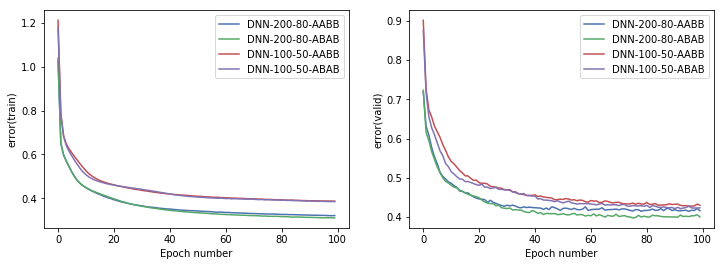

In [27]:
plot_whole(dictData)

(<Figure size 864x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a30d843c8>)

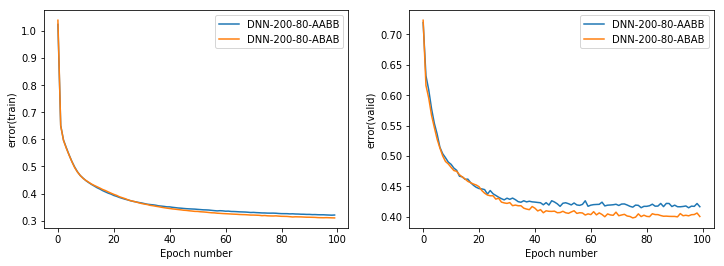

In [8]:
plot_whole(dictData)

# test performance

In [7]:
import time
def test(X, model_location, save_name, n_input, n_output, n_hidden_1 = 200, n_hidden_2 = 80, n_hidden_3 = 80, n_hidden_4 = 40,binary=0):
    tf.reset_default_graph()
    x = tf.placeholder("float", [None, n_input])
    is_train = tf.placeholder("bool")
    input_keep_prob = tf.placeholder(tf.float32)
    hidden_keep_prob = tf.placeholder(tf.float32)
    weights, biases = ini_weights4(n_input, n_hidden_1, n_hidden_2, n_hidden_3, n_hidden_4, n_output)
    pred = multilayer_perceptron4(x, weights, biases, input_keep_prob, hidden_keep_prob)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, model_location)
        start_time = time.time()
        y_pred = sess.run(pred, feed_dict={x: X, input_keep_prob: 1, hidden_keep_prob: 1, is_train: False})
        testtime = time.time() - start_time
        # print("testing time: %0.2f s" % testtime)
        if binary==1:
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
        sio.savemat(save_name, {'pred': y_pred})
    return y_pred
def DtoComplex(XX, dim):
    size=XX.shape[1]
    X=np.empty( (XX.shape[0], dim), dtype= np.complex128 )
    for loop in range(dim):
        X[:,loop]=XX[:,loop*2]
        X[:,loop]=X[:,loop]+1j*XX[:, loop*2+1]
    return X
def DABtoComplex(XX, dim):
    size=XX.shape[1]
    X=np.empty( (XX.shape[0], dim), dtype= np.complex128 )
    X.real[:,:]=XX[:,0:dim]
    X.imag[:,:]=XX[:,dim:2*dim]
    return X
def obj_sum_rate(xtest, y_pred,M,N,K, samples):
    # H ： sampels*12
    sum_rate=[]
    for i in range(samples):
        rate_nn=0
        H=np.reshape(xtest[i,:],[K,M,N])
        pnn=np.reshape(y_pred[i,:],[K,M,N])      
        for j in range(K):
            if j==0:
                rate_nn = rate_nn+np.real(np.log2( \
                                                  np.linalg.det(np.eye(M)+np.dot(np.dot(np.transpose(H[j,:,:]),np.transpose(pnn[j,:,:])), H[j,:,:].conj()))))
            else:
                pnn[j,:,:]=np.transpose(pnn[j,:,:])+pnn[j-1,:,:]
                rate_nn = rate_nn+np.real(np.log2(np.linalg.det(np.eye(M)+np.dot(np.dot(np.transpose(H[j,:,:]), pnn[j,:,:]), H[j,:,:].conj())) \
                                                  /np.linalg.det((np.eye(M)+np.dot(np.dot(np.transpose(H[j,:,:]),pnn[j-1,:,:]),H[j,:,:].conj())))))
                
        sum_rate.append(rate_nn)
    return sum_rate


def CDF_Plot(sumRate1, sumRate2, label1= 'DNN', label2= 'IWF'):
    a = np.array(sumRate1) # your array of numbers
    num_bins1 = np.linspace(0, max(sumRate1), 50)
    counts1, bin_edges1 = np.histogram(a, bins='auto', normed=True)
    cdf1 = np.cumsum(counts1*np.diff(bin_edges1))

    b = np.array(sumRate2) # your array of numbers
    num_bins2 = np.linspace(0, max(sumRate2), 50)
    counts2, bin_edges2 = np.histogram(b, bins='auto', normed=True)
    cdf2 = np.cumsum(counts2*np.diff(bin_edges2))
    
    plt.xlabel('sum-rate')
    plt.plot(bin_edges1[1:], cdf1, color='black', label=label1)
    plt.plot(bin_edges2[1:],cdf2,color='red', label=label2)
    plt.legend()
    return 0

def histPlot(sumRate1,sumRate2, label=['DNN', 'IWF']):
#     plt.figure('%d'%K)
    plt.style.use('seaborn-deep')
    data = np.vstack([sumRate1, sumRate2]).T
    bins = np.linspace(0, max(sumRate2),50)
    plt.hist(data, bins, alpha=0.7, label=label)
#     plt.legend(loc='upper right')
    plt.xlim([0, 10])
    plt.xlabel('sum-rate')
    plt.ylabel('number of samples')
    #     plt.savefig('Histogram_%d.eps'%K, format='eps', dpi=1000)
    plt.show()
    return 0
def performance(sumRate1,sumRate2, num):
# sumRate1, IWF; sumRate2, NN
    print('Sum-rate: IWF: %0.3f, DNN: %0.3f'%(sum(sumRate1)/num, sum(sumRate2)/num))
    print('Ratio: DNN: %0.3f%%\n' % (sum(sumRate2) / sum(sumRate1)* 100))
    return 0

def testPerformance(model_location, save_name, n_input, n_output,dim, M, N, K,samples):
    ypred=test(Xtest, model_location, save_name+'%s'%('test'), n_input,n_output, binary=0)
    trainPred=test(x_train, model_location, save_name+"%s"%('train'), n_input,n_output, binary=0)
    valPred=test(x_val, model_location, save_name+"%s"%('val'), n_input,n_output, binary=0)
    x=DABtoComplex(X,dim)
    xtest=DABtoComplex(Xtest,dim)
    ytest=DABtoComplex(Ytest,dim)
    ypred=DABtoComplex(ypred,dim)

    # train & val
    xtrain=DABtoComplex(x_train,dim)
    ytrain=DABtoComplex(y_train,dim)
    trainPred=DABtoComplex(trainPred,dim)
    xval=DABtoComplex(x_val,dim)
    yval=DABtoComplex(y_val,dim)
    valPred=DABtoComplex(valPred,dim)

    # test
    nnsumRate=obj_sum_rate(xtest, ypred, M, N, K, samples)
    IWFsumRate=obj_sum_rate(xtest, ytest, M, N, K, samples)
    #trian
    nnSRTrain=obj_sum_rate(xtrain, trainPred, M, N, K, samples)
    IWFSRTrain=obj_sum_rate(xtrain, ytrain, M, N, K, samples)
    # validation
    IWFSRVal=obj_sum_rate(xval, yval, M, N, K, samples)
    nnSRVal=obj_sum_rate(xval, valPred, M, N, K, samples)

    plt.figure(1)
    plt.subplot(311)
    plt.title('CDF AnalysisTest')
    CDF_Plot(nnsumRate,IWFsumRate, 'DNNTest', 'IWFTest')
    plt.subplot(312)
    plt.title('CDF Analysis_Train')
    CDF_Plot(nnSRTrain,IWFSRTrain, 'DNNTrain', 'IWFTrain')
    plt.subplot(313)
    plt.title('CDF Analysis_val')
    CDF_Plot(nnSRVal,IWFSRVal, 'DNNVal', 'IWFVal')
    
    plt.figure(2)
    plt.subplot(211)
    plt.title('Hist AnalysisTest')
    histPlot(nnsumRate,IWFsumRate, ['DNNTest', 'IWFTest'])
    plt.subplot(212)
    plt.title('Hist Analysis_Train')
    histPlot(nnSRTrain,IWFSRTrain, ['DNNTrain', 'IWFTrain'])
    
    performance(IWFsumRate, nnsumRate, samples)
    performance(IWFSRTrain, nnSRTrain, samples)
    return 0
    

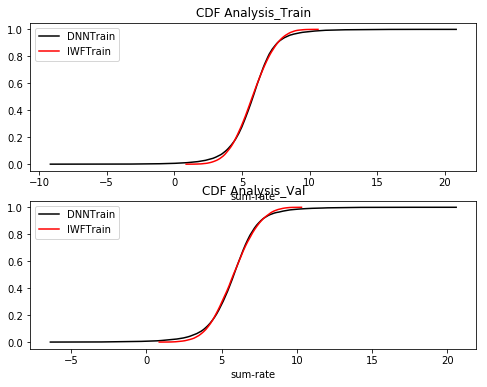

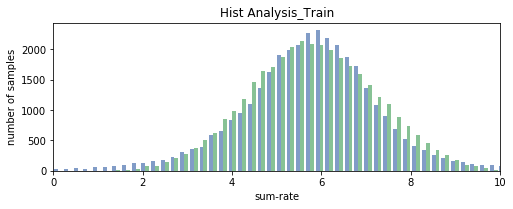

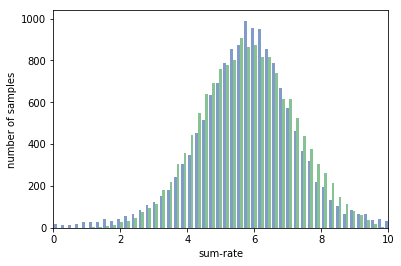


 Train:
Sum-rate: IWF: 5.784, DNN: 5.771
Ratio: DNN: 99.774%

Val:
Sum-rate: IWF: 5.797, DNN: 5.775
Ratio: DNN: 99.606%



0

In [34]:
trainPred=model.predict(x_train)

# encoder_x_val=encoder.predict(x_val_standard)
valPred=model.predict(x_val)

# encoder_x_test=encoder.predict(Xtest_standard)
# ypred=model.predict(Xtest)
D=12

# test
# xtest=DABtoComplex(Xtest,D)
# ytest=DABtoComplex(Ytest,D)
# ypred=DABtoComplex(ypred,D)

# train & val
xtrain=DABtoComplex(x_train,D)
ytrain=DABtoComplex(y_train,D)
trainPred=DABtoComplex(trainPred,D)
xval=DABtoComplex(x_val,D)
yval=DABtoComplex(y_val,D)
valPred=DABtoComplex(valPred,D)
M=2
N=2
K=3
# test
# nnsumRate=obj_sum_rate(xtest, ypred,M,N,K, 5000)
# IWFsumRate=obj_sum_rate(xtest, ytest,M,N,K, 5000)
#trian
nnSRTrain=obj_sum_rate(xtrain, trainPred,M,N,K, 35000)
IWFSRTrain=obj_sum_rate(xtrain, ytrain,M,N,K, 35000)
# validation
IWFSRVal=obj_sum_rate(xval, yval,M,N,K, 15000)
nnSRVal=obj_sum_rate(xval, valPred,M,N,K, 15000)


f1=plt.figure(figsize=(8,6))
# plt.subplot(311)
# plt.title('CDF AnalysisTest')
# CDF_Plot(nnsumRate,IWFsumRate, 'DNNTest', 'IWFTest')

ax1=f1.add_subplot(211)
ax1.set_title('CDF Analysis_Train')
CDF_Plot(nnSRTrain,IWFSRTrain, 'DNNTrain', 'IWFTrain')
ax2=f1.add_subplot(212)
ax2.set_title('CDF Analysis_Val')
CDF_Plot(nnSRVal,IWFSRVal, 'DNNTrain', 'IWFTrain')

f2=plt.figure(figsize=(8,6))
# plt.figure(figsize=(8,6))
# plt.subplot(311)
# plt.title('Hist AnalysisTest')
# histPlot(nnsumRate,IWFsumRate, ['DNNTest', 'IWFTest'])
ax3=f2.add_subplot(211)
ax3.set_title('Hist Analysis_Train')
histPlot(nnSRTrain,IWFSRTrain, ['DNNTrain', 'IWFTrain'])
ax4=f2.add_subplot(212)
ax4.set_title('Hist Analysis_val')
histPlot(nnSRVal,IWFSRVal, ['DNNTrain', 'IWFTrain'])
# plt.show()
# print('test:')
# performance(IWFsumRate, nnsumRate, 5000)

print('\n Train:')
performance(IWFSRTrain, nnSRTrain, 35000)
print('Val:')
performance(IWFSRVal, nnSRVal, 15000)

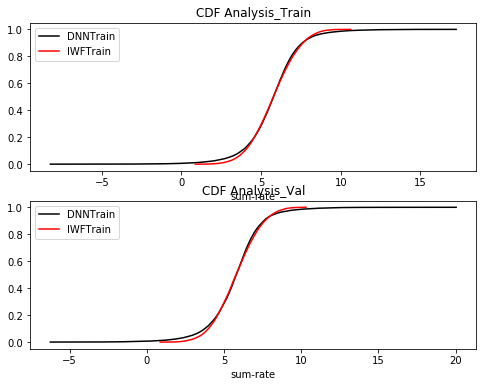

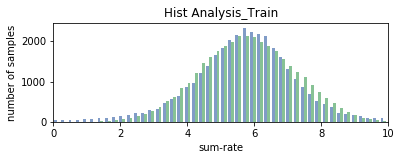

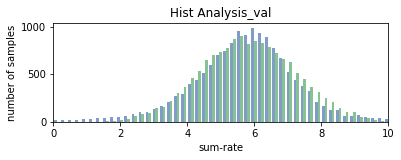

Train:
Sum-rate: IWF: 5.784, DNN: 5.729
Ratio: DNN: 99.046%

Val:
Sum-rate: IWF: 5.797, DNN: 5.729
Ratio: DNN: 98.832%



0

In [30]:
trainPred=modelABAB.predict(x_train2)

# encoder_x_val=encoder.predict(x_val_standard)
valPred=modelABAB.predict(x_val2)

# encoder_x_test=encoder.predict(Xtest_standard)
# ypred=model.predict(Xtest)
D=12

# test
# xtest=DABtoComplex(Xtest,D)
# ytest=DABtoComplex(Ytest,D)
# ypred=DABtoComplex(ypred,D)

# train & val
xtrain=DtoComplex(x_train2,D)
ytrain=DtoComplex(y_train2,D)
trainPred=DtoComplex(trainPred,D)
xval=DtoComplex(x_val2,D)
yval=DtoComplex(y_val2,D)
valPred=DtoComplex(valPred,D)
M=2
N=2
K=3
# test
# nnsumRate=obj_sum_rate(xtest, ypred,M,N,K, 5000)
# IWFsumRate=obj_sum_rate(xtest, ytest,M,N,K, 5000)
#trian
nnSRTrain=obj_sum_rate(xtrain, trainPred,M,N,K, 35000)
IWFSRTrain=obj_sum_rate(xtrain, ytrain,M,N,K, 35000)
# validation
IWFSRVal=obj_sum_rate(xval, yval,M,N,K, 15000)
nnSRVal=obj_sum_rate(xval, valPred,M,N,K, 15000)

# plt.figure(1)
plt.figure(1,figsize=(8,6))
# plt.subplot(311)
# plt.title('CDF AnalysisTest')
# CDF_Plot(nnsumRate,IWFsumRate, 'DNNTest', 'IWFTest')
plt.subplot(211)
plt.title('CDF Analysis_Train')
CDF_Plot(nnSRTrain,IWFSRTrain, 'DNNTrain', 'IWFTrain')
plt.subplot(212)
plt.title('CDF Analysis_Val')
CDF_Plot(nnSRVal,IWFSRVal, 'DNNTrain', 'IWFTrain')

plt.figure(2)
# plt.figure(figsize=(8,6))
# plt.subplot(311)
# plt.title('Hist AnalysisTest')
# histPlot(nnsumRate,IWFsumRate, ['DNNTest', 'IWFTest'])
plt.subplot(211)
plt.title('Hist Analysis_Train')
histPlot(nnSRTrain,IWFSRTrain, ['DNNTrain', 'IWFTrain'])
plt.subplot(212)
plt.title('Hist Analysis_val')
histPlot(nnSRVal,IWFSRVal, ['DNNTrain', 'IWFTrain'])
# plt.show()
# print('test:')
# performance(IWFsumRate, nnsumRate, 5000)
print('Train:')
performance(IWFSRTrain, nnSRTrain, 35000)
print('Val:')
performance(IWFSRVal, nnSRVal, 15000)

In [41]:
mat = np.array([1,2,3,4,5,6,7,8,9,10,11,12]).T
mat.reshape(2,2,3)

array([[[ 1,  2,  3],
        [ 4,  5,  6]],

       [[ 7,  8,  9],
        [10, 11, 12]]])

check code for reshape and transpose

In [12]:
K=3
M=2
N=2
H=np.reshape(np.transpose(xtest[1,:]),[K,M,N])
print(H)
# pnn=np.reshape(y_pred[i,:],[K,M,N],order="F")      

[[[ 0.3457001 +0.22994444j  0.51398541+0.96894739j]
  [ 0.73163844-0.53381493j -0.21456514-1.21022487j]]

 [[ 0.20779851-0.07229633j -0.55669301-0.17072884j]
  [ 0.62819058+0.22571325j -0.81110105+0.22122444j]]

 [[-0.75580555-0.61156245j -0.57240202-0.02124948j]
  [-2.0819233 -0.11658707j  1.01708846+0.44385608j]]]


In [9]:
xtest=DABtoComplex(Xtest,12)
xtest[1,:]

array([ 0.3457001 +0.22994444j,  0.73163844-0.53381493j,
        0.51398541+0.96894739j, -0.21456514-1.21022487j,
        0.20779851-0.07229633j, -0.55669301-0.17072884j,
        0.62819058+0.22571325j, -0.81110105+0.22122444j,
       -0.75580555-0.61156245j, -0.57240202-0.02124948j,
       -2.0819233 -0.11658707j,  1.01708846+0.44385608j])

In [13]:
print(np.linalg.norm(H[0,:,:],ord=1) )   

2.32593003630361


In [15]:
mean=0
for i in range(K):
    
    H[i,:,:] = np.transpose(H[i,:,:])
    mean=mean+np.mean(np.linalg.norm(H[i,:,:],ord=1)**2)
print(mean)

16.78276707526493


In [35]:
H[0,:,:] = np.reshape(H[0,:,:],[2,2])
print(H)

[[[ 0.3457001 +0.22994444j  0.73163844-0.53381493j]
  [ 0.51398541+0.96894739j -0.21456514-1.21022487j]]

 [[ 0.20779851-0.07229633j -0.55669301-0.17072884j]
  [ 0.62819058+0.22571325j -0.81110105+0.22122444j]]

 [[-0.75580555-0.61156245j -0.57240202-0.02124948j]
  [-2.0819233 -0.11658707j  1.01708846+0.44385608j]]]


In [30]:
H

array([[[ 0.3457001 +0.22994444j,  0.62819058+0.22571325j],
        [-0.21456514-1.21022487j, -0.57240202-0.02124948j]],

       [[ 0.73163844-0.53381493j, -0.81110105+0.22122444j],
        [ 0.20779851-0.07229633j, -2.0819233 -0.11658707j]],

       [[ 0.51398541+0.96894739j, -0.75580555-0.61156245j],
        [-0.55669301-0.17072884j,  1.01708846+0.44385608j]]])

In [78]:
ypred[1,:]

array([ 5.03639206-0.00217419j, -0.39654902-1.30403528j,
       -0.32278047+1.26792348j,  4.59057737+0.0372017j ,
        0.06919308+0.0348714j ,  0.28737925+0.24074153j,
        0.25605182-0.23459942j,  0.18934757+0.03064339j,
        4.86648825+0.02810832j, -1.00111249+1.02259399j,
       -1.03977448-1.03052437j,  0.82674343+0.03133142j])

In [84]:
ytest[1,:]

array([ 0.3410883 +1.11022302e-16j,  1.01631837+6.69374289e-01j,
        1.01631837-6.69374289e-01j,  4.34188149+9.15933995e-16j,
        0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
        0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
        4.83346841+1.33226763e-15j, -1.27633706-8.41572591e-01j,
       -1.27633706+8.41572591e-01j,  0.4835618 -3.60822483e-16j])

In [91]:
Ytest[1,:]
print(Ytest[1,:])
ytest=DABtoComplex(Ytest,D)
print(ytest[1,:])

[ 3.41088300e-01  1.01631837e+00  1.01631837e+00  4.34188149e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.83346841e+00 -1.27633706e+00 -1.27633706e+00  4.83561804e-01
  1.11022302e-16  6.69374289e-01 -6.69374289e-01  9.15933995e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.33226763e-15 -8.41572591e-01  8.41572591e-01 -3.60822483e-16]
[ 0.3410883 +1.11022302e-16j  1.01631837+6.69374289e-01j
  1.01631837-6.69374289e-01j  4.34188149+9.15933995e-16j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  4.83346841+1.33226763e-15j -1.27633706-8.41572591e-01j
 -1.27633706+8.41572591e-01j  0.4835618 -3.60822483e-16j]


In [13]:
xtest=DABtoComplex(Xtest,12)
# H=np.reshape(xtest[1,:],[K,M,N])
H=np.reshape(xtest[1,:],[K,M,N])
print(xtest[1,:])

[ 0.3457001 +0.22994444j  0.73163844-0.53381493j  0.51398541+0.96894739j
 -0.21456514-1.21022487j  0.20779851-0.07229633j -0.55669301-0.17072884j
  0.62819058+0.22571325j -0.81110105+0.22122444j -0.75580555-0.61156245j
 -0.57240202-0.02124948j -2.0819233 -0.11658707j  1.01708846+0.44385608j]


In [25]:
rate_nn=0
K=3
M=2
N=2
xtest=DABtoComplex(Xtest,12)
H=np.reshape(xtest[1,:],[K,M,N])
print(H)
ytest=DABtoComplex(Ytest,12)
pnn=np.reshape(ytest[1,:],[K,M,N]) 
print(pnn)
print('===============')
# rate_n=0
for j in range(K):
    if j==0:
        print(H[0,:,:])
        print(H[0,:,:].conj().T)
        print('========222222222======')
        rate_nn = rate_nn+np.real(np.log2(np.linalg.det(np.eye(M)+np.dot(np.dot(np.transpose(H[j,:,:]),np.transpose(pnn[j,:,:])), H[j,:,:].conj()))))
        
        l1=np.dot(np.transpose(H[0,:,:]) ,np.transpose(pnn[0,:,:]))
        
        print(l1)
        print(np.dot(l1,  H[j,:,:].conj()))
        print('========1212121========')
        print(np.transpose(H[j,:,:]) )
        print(np.transpose(pnn[j,:,:]))
        print( H[j,:,:])
        print('========3======')
        print(rate_nn)
    else:
        pnn[j,:,:]=np.transpose(pnn[j,:,:])+pnn[j-1,:,:]
        print(pnn)
        rate_nn = rate_nn+np.real(np.log2(np.linalg.det(np.eye(M)+np.dot(np.dot(np.transpose(H[j,:,:]), pnn[j,:,:]), H[j,:,:].conj()))/np.linalg.det((np.eye(M)+np.dot(np.dot(np.transpose(H[j,:,:]),pnn[j-1,:,:]),H[j,:,:].conj())))))
        print(rate_nn)

[[[ 0.3457001 +0.22994444j  0.73163844-0.53381493j]
  [ 0.51398541+0.96894739j -0.21456514-1.21022487j]]

 [[ 0.20779851-0.07229633j -0.55669301-0.17072884j]
  [ 0.62819058+0.22571325j -0.81110105+0.22122444j]]

 [[-0.75580555-0.61156245j -0.57240202-0.02124948j]
  [-2.0819233 -0.11658707j  1.01708846+0.44385608j]]]
[[[ 0.3410883 +1.11022302e-16j  1.01631837+6.69374289e-01j]
  [ 1.01631837-6.69374289e-01j  4.34188149+9.15933995e-16j]]

 [[ 0.        +0.00000000e+00j  0.        +0.00000000e+00j]
  [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j]]

 [[ 4.83346841+1.33226763e-15j -1.27633706-8.41572591e-01j]
  [-1.27633706+8.41572591e-01j  0.4835618 -3.60822483e-16j]]]
[[ 0.3457001 +0.22994444j  0.73163844-0.53381493j]
 [ 0.51398541+0.96894739j -0.21456514-1.21022487j]]
[[ 0.3457001 -0.22994444j  0.51398541-0.96894739j]
 [ 0.73163844+0.53381493j -0.21456514+1.21022487j]]
========222222222======
[[-0.0083014 +1.40723901j  2.73692398+4.20934873j]
 [ 0.84158023-1.55567618j -0.545360

In [11]:
# 2-D array: 2 x 3
two_dim_matrix_one = np.array([[1, 2, 3], [4, 5, 6]])
# 2-D array: 3 x 2
two_dim_matrix_two = np.array([[1, 2], [3, 4], [5, 6]])

two_multi_res = np.dot(two_dim_matrix_one, two_dim_matrix_two)
print('two_multi_res: %s' %(two_multi_res),'\n',two_dim_matrix_one,'\n',two_dim_matrix_two)


two_multi_res: [[22 28]
 [49 64]] 
 [[1 2 3]
 [4 5 6]] 
 [[1 2]
 [3 4]
 [5 6]]


In [7]:
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib
from sklearn.neural_network import MLPClassifier,MLPRegressor
MNK2_2_3Modeltest=MLPRegressor(activation='relu', learning_rate_init=0.001 ,solver='sgd',max_iter=100
                    ,alpha=1e-5,hidden_layer_sizes=(200,80,80), random_state=1)
MNK2_2_3Modeltest.fit(x_train, y_train)

/Users/user/anaconda2/envs/haha/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200, 80, 80), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

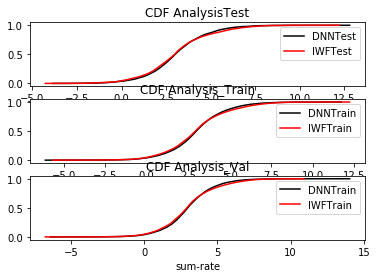

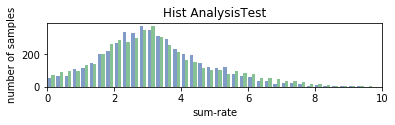

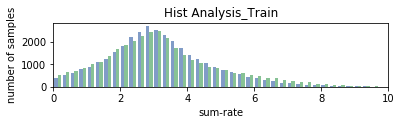

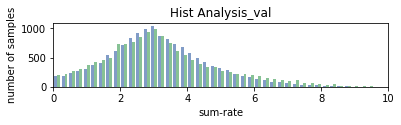

test:
Sum-rate: IWF: 3.077, DNN: 3.080
Ratio: DNN: 100.086%

Train:
Sum-rate: IWF: 3.051, DNN: 3.043
Ratio: DNN: 99.768%

Val:
Sum-rate: IWF: 3.032, DNN: 3.023
Ratio: DNN: 99.706%



0

In [39]:
trainPred=MNK2_2_3Modeltest.predict(x_train)

# encoder_x_val=encoder.predict(x_val_standard)
valPred=MNK2_2_3Modeltest.predict(x_val)

# encoder_x_test=encoder.predict(Xtest_standard)
ypred=MNK2_2_3Modeltest.predict(Xtest)
D=12

# test
xtest=DABtoComplex(Xtest,D)
ytest=DABtoComplex(Ytest,D)
ypred=DABtoComplex(ypred,D)

# train & val
xtrain=DABtoComplex(x_train,D)
ytrain=DABtoComplex(y_train,D)
trainPred=DABtoComplex(trainPred,D)
xval=DABtoComplex(x_val,D)
yval=DABtoComplex(y_val,D)
valPred=DABtoComplex(valPred,D)
M=2
N=2
K=3
# test
nnsumRate=obj_sum_rate(xtest, ypred,M,N,K, 5000)
IWFsumRate=obj_sum_rate(xtest, ytest,M,N,K, 5000)
#trian
nnSRTrain=obj_sum_rate(xtrain, trainPred,M,N,K, 35000)
IWFSRTrain=obj_sum_rate(xtrain, ytrain,M,N,K, 35000)
# validation
IWFSRVal=obj_sum_rate(xval, yval,M,N,K, 15000)
nnSRVal=obj_sum_rate(xval, valPred,M,N,K, 15000)

plt.figure(1)
plt.subplot(311)
plt.title('CDF AnalysisTest')
CDF_Plot(nnsumRate,IWFsumRate, 'DNNTest', 'IWFTest')
plt.subplot(312)
plt.title('CDF Analysis_Train')
CDF_Plot(nnSRTrain,IWFSRTrain, 'DNNTrain', 'IWFTrain')
plt.subplot(313)
plt.title('CDF Analysis_Val')
CDF_Plot(nnSRVal,IWFSRVal, 'DNNTrain', 'IWFTrain')

plt.figure(2)
plt.subplot(311)
plt.title('Hist AnalysisTest')
histPlot(nnsumRate,IWFsumRate, ['DNNTest', 'IWFTest'])
plt.subplot(312)
plt.title('Hist Analysis_Train')
histPlot(nnSRTrain,IWFSRTrain, ['DNNTrain', 'IWFTrain'])
plt.subplot(313)
plt.title('Hist Analysis_val')
histPlot(nnSRVal,IWFSRVal, ['DNNTrain', 'IWFTrain'])
print('test:')
performance(IWFsumRate, nnsumRate, 5000)
print('Train:')
performance(IWFSRTrain, nnSRTrain, 35000)
print('Val:')
performance(IWFSRVal, nnSRVal, 15000)

In [14]:
# encoded_val = encoder.predict(x_val)
# decoded_val = decoder.predict(encoded_val)
encoded_train = encoder.predict(x_train_standard)
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib
from sklearn.neural_network import MLPClassifier,MLPRegressor
MNK2_2_3Model=MLPRegressor(activation='relu', learning_rate_init=0.001 ,solver='sgd',max_iter=100
                    ,alpha=1e-5,hidden_layer_sizes=(200,80,80), random_state=1)
MNK2_2_3Model.fit(encoded_train, y_train)
# joblib.dump(clf, "MNK2_2_3Model.m"), clf = joblib.load("train_model.m")

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200, 80, 80), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [8]:
joblib.dump(MNK2_2_3Model, "MNK2_2_3Model.m")

['MNK2_2_3Model.m']

Important : calculate sum_rate use not standard data 

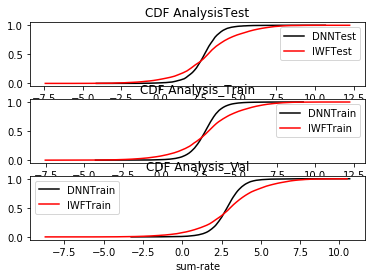

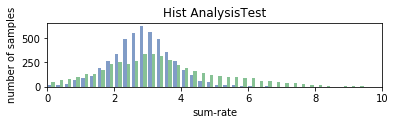

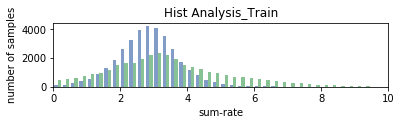

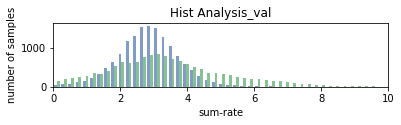

test:
Sum-rate: IWF: 3.080, DNN: 2.839
Ratio: DNN: 92.155%

Train:
Sum-rate: IWF: 3.053, DNN: 2.837
Ratio: DNN: 92.925%

Val:
Sum-rate: IWF: 3.046, DNN: 2.834
Ratio: DNN: 93.036%



0

In [15]:
trainPred=MNK2_2_3Model.predict(encoded_train)

encoder_x_val=encoder.predict(x_val_standard)
valPred=MNK2_2_3Model.predict(encoder_x_val)

encoder_x_test=encoder.predict(Xtest_standard)
ypred=MNK2_2_3Model.predict(encoder_x_test)
D=12

# test
xtest=DABtoComplex(Xtest,D)
ytest=DABtoComplex(Ytest,D)
ypred=DABtoComplex(ypred,D)

# train & val
xtrain=DABtoComplex(x_train,D)
ytrain=DABtoComplex(y_train,D)
trainPred=DABtoComplex(trainPred,D)
xval=DABtoComplex(x_val,D)
yval=DABtoComplex(y_val,D)
valPred=DABtoComplex(valPred,D)
M=2
N=2
K=3
# test
nnsumRate=obj_sum_rate(xtest, ypred,M,N,K, 5000)
IWFsumRate=obj_sum_rate(xtest, ytest,M,N,K, 5000)
#trian
nnSRTrain=obj_sum_rate(xtrain, trainPred,M,N,K, 35000)
IWFSRTrain=obj_sum_rate(xtrain, ytrain,M,N,K, 35000)
# validation
IWFSRVal=obj_sum_rate(xval, yval,M,N,K, 15000)
nnSRVal=obj_sum_rate(xval, valPred,M,N,K, 15000)

plt.figure(1)
plt.subplot(311)
plt.title('CDF AnalysisTest')
CDF_Plot(nnsumRate,IWFsumRate, 'DNNTest', 'IWFTest')
plt.subplot(312)
plt.title('CDF Analysis_Train')
CDF_Plot(nnSRTrain,IWFSRTrain, 'DNNTrain', 'IWFTrain')
plt.subplot(313)
plt.title('CDF Analysis_Val')
CDF_Plot(nnSRVal,IWFSRVal, 'DNNTrain', 'IWFTrain')

plt.figure(2)
plt.subplot(311)
plt.title('Hist AnalysisTest')
histPlot(nnsumRate,IWFsumRate, ['DNNTest', 'IWFTest'])
plt.subplot(312)
plt.title('Hist Analysis_Train')
histPlot(nnSRTrain,IWFSRTrain, ['DNNTrain', 'IWFTrain'])
plt.subplot(313)
plt.title('Hist Analysis_val')
histPlot(nnSRVal,IWFSRVal, ['DNNTrain', 'IWFTrain'])
print('test:')
performance(IWFsumRate, nnsumRate, 5000)
print('Train:')
performance(IWFSRTrain, nnSRTrain, 35000)
print('Val:')
performance(IWFSRVal, nnSRVal, 15000)

# without autoencoder

In [10]:
from sklearn.cross_validation import train_test_split
from sklearn.neural_network import MLPClassifier,MLPRegressor
T6_NN=MLPRegressor(activation='relu', learning_rate_init=0.001 ,solver='sgd',max_iter=100
                    ,alpha=1e-5,hidden_layer_sizes=(200,80,80), random_state=1)
T6_NN.fit(x_train_standard, y_train)

/Users/user/anaconda2/envs/haha/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200, 80, 80), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [12]:
import time
def obj_sum_rate(xtest, y_pred,M,N,K, samples):
    # H ： sampels*12
    sum_rate=[]
    for i in range(samples):
        rate_nn=0
        H=np.reshape(xtest[i,:],[K,M,N])
        pnn=np.reshape(y_pred[i,:],[K,M,N])      
        for j in range(K):
            if j==i:
                rate_nn = rate_nn+np.real(np.log2(np.linalg.det(np.eye(M)+H[j,:,:] * pnn[j,:,:] * np.transpose(H[j,:,:]))))
            else:
                pnn[j,:,:]=pnn[j,:,:]+pnn[j-1,:,:]
                rate_nn = rate_nn+np.real(np.log2(np.linalg.det(np.eye(M)+H[j,:,:] * pnn[j,:,:] * np.transpose(H[j,:,:]))/np.linalg.det((np.eye(M)+H[j,:,:] * pnn[j-1,:,:] * np.transpose(H[j,:,:])))))
        sum_rate.append(rate_nn)
    return sum_rate


5000
5000


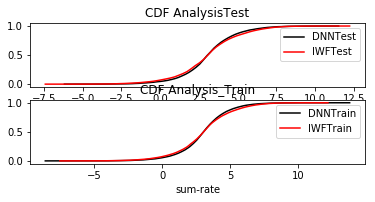

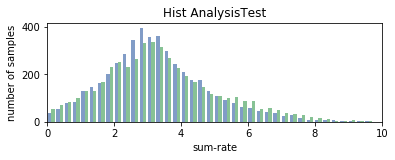

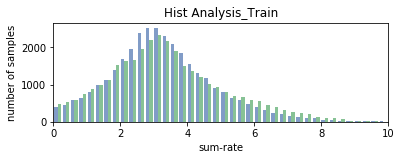

Test:
Sum-rate: IWF: 3.080, DNN: 3.102
Ratio: DNN: 100.695%

Train
Sum-rate: IWF: 3.053, DNN: 3.041
Ratio: DNN: 99.597%



0

In [13]:
# NN_y_train_pre_proba=T6_NN.predict_proba(T6_X_train)
trainPred=T6_NN.predict(x_train)

# NN_y_test_pre_proba=T6_NN.predict_proba(T6_X_test)
ypred=T6_NN.predict(Xtest)
D=12
# x=DABtoComplex(X,12)
xtest=DABtoComplex(Xtest,12)
ytest=DABtoComplex(Ytest,12)
ypred=DABtoComplex(ypred,12)

# train & val
xtrain=DABtoComplex(x_train,12)
ytrain=DABtoComplex(y_train,12)
trainPred=DABtoComplex(trainPred,12)
# xval=DABtoComplex(x_val,12)
# yval=DABtoComplex(y_val,12)
# valPred=DABtoComplex(valPred,12)

# test
nnsumRate=obj_sum_rate(xtest, ypred,2,2,3, 5000)
IWFsumRate=obj_sum_rate(xtest, ytest,2,2,3, 5000)
#trian
nnSRTrain=obj_sum_rate(xtrain, trainPred,2,2,3, 35000)
IWFSRTrain=obj_sum_rate(xtrain, ytrain,2,2,3, 35000)
# validation
# IWFSRVal=obj_sum_rate(xval, yval,2,2,3, 15000)
# nnSRVal=obj_sum_rate(xval, valPred,2,2,3, 15000)

print(len(nnsumRate))
print(len(IWFsumRate))
plt.figure(1)
plt.subplot(311)
plt.title('CDF AnalysisTest')
CDF_Plot(nnsumRate,IWFsumRate, 'DNNTest', 'IWFTest')
plt.subplot(312)
plt.title('CDF Analysis_Train')
CDF_Plot(nnSRTrain,IWFSRTrain, 'DNNTrain', 'IWFTrain')

plt.figure(2)
plt.subplot(211)
plt.title('Hist AnalysisTest')
histPlot(nnsumRate,IWFsumRate, ['DNNTest', 'IWFTest'])
plt.subplot(212)
plt.title('Hist Analysis_Train')
histPlot(nnSRTrain,IWFSRTrain, ['DNNTrain', 'IWFTrain'])
print('Test:')
performance(IWFsumRate, nnsumRate, 5000)
print('Train')
performance(IWFSRTrain, nnSRTrain, 35000)

In [176]:
x_train[1,:]

array([-0.08199763, -0.13753893, -0.13632327, -0.23762443, -0.12991279,
       -1.18839649,  0.21623548, -0.41368963, -0.85611216,  1.73029291,
        1.06054161, -0.61322595, -0.86117737, -0.01017407,  0.77966571,
       -0.17977249, -0.01087996, -1.2218905 ,  0.34821747,  0.17680233,
       -0.51402672,  0.10411906, -0.14797079,  0.05718126])

In [175]:
np.reshape(x_train[1,:],[3,2,4])

array([[[-0.08199763, -0.13753893, -0.13632327, -0.23762443],
        [-0.12991279, -1.18839649,  0.21623548, -0.41368963]],

       [[-0.85611216,  1.73029291,  1.06054161, -0.61322595],
        [-0.86117737, -0.01017407,  0.77966571, -0.17977249]],

       [[-0.01087996, -1.2218905 ,  0.34821747,  0.17680233],
        [-0.51402672,  0.10411906, -0.14797079,  0.05718126]]])

In [177]:
np.reshape(x_train[1,:],[3,2,4])[1,:,:]

array([[-0.85611216,  1.73029291,  1.06054161, -0.61322595],
       [-0.86117737, -0.01017407,  0.77966571, -0.17977249]])

In [23]:
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

x_val -= mean
x_val /= std


from sklearn.cross_validation import train_test_split
from sklearn.neural_network import MLPClassifier,MLPRegressor
NN=MLPRegressor(activation='relu', learning_rate_init=0.001 ,solver='sgd',max_iter=100
                    ,alpha=1e-5,hidden_layer_sizes=(200,80,80), random_state=1)
NN.fit(x_train, y_train)


/Users/user/anaconda2/envs/haha/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200, 80, 80), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

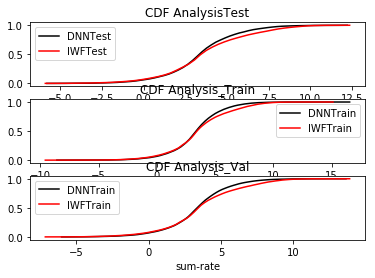

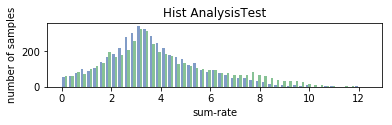

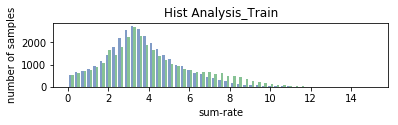

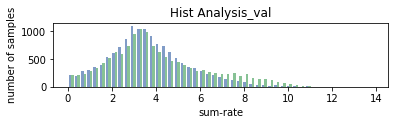

test:
Sum-rate: IWF: 3.693, DNN: 3.400
Ratio: DNN: 92.068%

Train:
Sum-rate: IWF: 3.633, DNN: 3.359
Ratio: DNN: 92.465%

Val:
Sum-rate: IWF: 3.648, DNN: 3.344
Ratio: DNN: 91.662%



0

In [24]:
trainPred=NN.predict(x_train)

# NN_y_test_pre_proba=T6_NN.predict_proba(T6_X_test)
valPred=NN.predict(x_val)
ypred=NN.predict(Xtest)
D=12

# test
xtest=DABtoComplex(Xtest,D)
ytest=DABtoComplex(Ytest,D)
ypred=DABtoComplex(ypred,D)

# train & val
xtrain=DABtoComplex(x_train,D)
ytrain=DABtoComplex(y_train,D)
trainPred=DABtoComplex(trainPred,D)
xval=DABtoComplex(x_val,D)
yval=DABtoComplex(y_val,D)
valPred=DABtoComplex(valPred,D)
M=2
N=2
K=3
# test
nnsumRate=obj_sum_rate(xtest, ypred,M,N,K, 5000)
IWFsumRate=obj_sum_rate(xtest, ytest,M,N,K, 5000)
#trian
nnSRTrain=obj_sum_rate(xtrain, trainPred,M,N,K, 35000)
IWFSRTrain=obj_sum_rate(xtrain, ytrain,M,N,K, 35000)
# validation
IWFSRVal=obj_sum_rate(xval, yval,M,N,K, 15000)
nnSRVal=obj_sum_rate(xval, valPred,M,N,K, 15000)

plt.figure(1)
plt.subplot(311)
plt.title('CDF AnalysisTest')
CDF_Plot(nnsumRate,IWFsumRate, 'DNNTest', 'IWFTest')
plt.subplot(312)
plt.title('CDF Analysis_Train')
CDF_Plot(nnSRTrain,IWFSRTrain, 'DNNTrain', 'IWFTrain')
plt.subplot(313)
plt.title('CDF Analysis_Val')
CDF_Plot(nnSRVal,IWFSRVal, 'DNNTrain', 'IWFTrain')

plt.figure(2)
plt.subplot(311)
plt.title('Hist AnalysisTest')
histPlot(nnsumRate,IWFsumRate, ['DNNTest', 'IWFTest'])
plt.subplot(312)
plt.title('Hist Analysis_Train')
histPlot(nnSRTrain,IWFSRTrain, ['DNNTrain', 'IWFTrain'])
plt.subplot(313)
plt.title('Hist Analysis_val')
histPlot(nnSRVal,IWFSRVal, ['DNNTrain', 'IWFTrain'])
print('test:')
performance(IWFsumRate, nnsumRate, 5000)
print('Train:')
performance(IWFSRTrain, nnSRTrain, 35000)
print('Val:')
performance(IWFSRVal, nnSRVal, 15000)

10000
10000


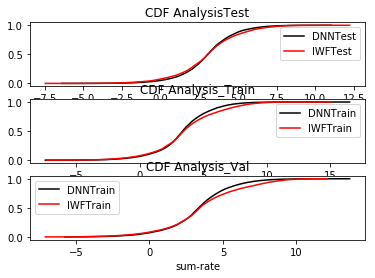

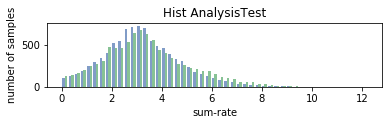

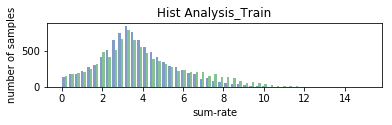

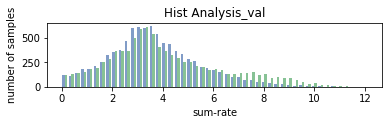

test:
Sum-rate: IWF: 3.036, DNN: 3.027
Ratio: DNN: 99.704%

Train:
Sum-rate: IWF: 3.638, DNN: 3.389
Ratio: DNN: 93.140%

Val:
Sum-rate: IWF: 3.629, DNN: 3.330
Ratio: DNN: 91.751%



0

In [25]:
# NN_y_train_pre_proba=T6_NN.predict_proba(T6_X_train)
DateLocation='MIMO10000_3test.mat'
DataTest10000 = sio.loadmat(DateLocation)#load data
Xtest=DataTest10000['X']
Xtest = np.transpose(Xtest)
Ytest=DataTest10000['Y']
Ytest = np.transpose(Ytest)
Xtest = np.column_stack((np.real(Xtest), np.imag(Xtest)))
Ytest = np.column_stack((np.real(Ytest), np.imag(Ytest)))

Xtest -= mean
Xtest /= std

trainPred=NN.predict(x_train)

# NN_y_test_pre_proba=T6_NN.predict_proba(T6_X_test)
valPred=NN.predict(x_val)
ypred=NN.predict(Xtest)
D=12
x=DABtoComplex(X,12)
xtest=DABtoComplex(Xtest,12)
ytest=DABtoComplex(Ytest,12)
ypred=DABtoComplex(ypred,12)

# train & val
xtrain=DABtoComplex(x_train,12)
ytrain=DABtoComplex(y_train,12)
trainPred=DABtoComplex(trainPred,12)
xval=DABtoComplex(x_val,12)
yval=DABtoComplex(y_val,12)
valPred=DABtoComplex(valPred,12)

# test
nnsumRate=obj_sum_rate(xtest, ypred,2,2,3, 10000)
IWFsumRate=obj_sum_rate(xtest, ytest,2,2,3, 10000)
#trian
nnSRTrain=obj_sum_rate(xtrain, trainPred,2,2,3, 10000)
IWFSRTrain=obj_sum_rate(xtrain, ytrain,2,2,3, 10000)
# validation
IWFSRVal=obj_sum_rate(xval, yval,2,2,3, 10000)
nnSRVal=obj_sum_rate(xval, valPred,2,2,3, 10000)

print(len(nnsumRate))
print(len(IWFsumRate))
plt.figure(1)
plt.subplot(311)
plt.title('CDF AnalysisTest')
CDF_Plot(nnsumRate,IWFsumRate, 'DNNTest', 'IWFTest')
plt.subplot(312)
plt.title('CDF Analysis_Train')
CDF_Plot(nnSRTrain,IWFSRTrain, 'DNNTrain', 'IWFTrain')
plt.subplot(313)
plt.title('CDF Analysis_Val')
CDF_Plot(nnSRVal,IWFSRVal, 'DNNTrain', 'IWFTrain')

plt.figure(2)
plt.subplot(311)
plt.title('Hist AnalysisTest')
histPlot(nnsumRate,IWFsumRate, ['DNNTest', 'IWFTest'])
plt.subplot(312)
plt.title('Hist Analysis_Train')
histPlot(nnSRTrain,IWFSRTrain, ['DNNTrain', 'IWFTrain'])
plt.subplot(313)
plt.title('Hist Analysis_val')
histPlot(nnSRVal,IWFSRVal, ['DNNTrain', 'IWFTrain'])
print('test:')
performance(IWFsumRate, nnsumRate, 10000)
print('Train:')
performance(IWFSRTrain, nnSRTrain, 10000)
print('Val:')
performance(IWFSRVal, nnSRVal, 10000)

In [111]:
ypred[1:3,:]

array([[ 1.42175215e+00-0.3584642j ,  1.06539132e+00+0.35622283j,
         2.09572018e+00+0.00163528j,  3.09086705e+00+0.19556217j,
         2.05553376e-01+0.0444532j ,  6.97960820e-01+0.26431803j,
         4.90821792e+00-0.28048227j,  1.16491789e+00-0.01325627j,
         5.58591221e+00-0.02987156j, -6.55108826e-01-0.74305652j,
        -1.75869249e+00+0.68134813j, -6.31885531e-01+0.65291631j],
       [ 2.60392776e-01+0.18614841j,  3.81974744e-01-0.03832029j,
         5.88773488e-02+0.18761063j,  1.81613957e+00+1.18317869j,
         5.86069120e+00+1.20531087j,  1.90235580e+00+1.183425j  ,
         2.54515107e+00-1.15543095j,  3.48181817e+00-1.14216493j,
         6.02916641e-01+0.00495986j,  2.17272318e+00-1.02539405j,
         1.04346695e-03-0.04866601j,  4.30208619e+00-0.02111415j]])

In [83]:
# Functions for deep neural network weights initialization
def ini_weights(n_input, n_hidden_1, n_hidden_2, n_hidden_3, n_output):
    weights = {
        'h1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1]) / np.sqrt(n_input)),
        'h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2]) / np.sqrt(n_hidden_1)),
        'h3': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_3]) / np.sqrt(n_hidden_2)),
        'out': tf.Variable(tf.truncated_normal([n_hidden_3, n_output])) / n_hidden_3,
    }
    biases = {
        'b1': tf.Variable(tf.ones([n_hidden_1]) * 0.1),
        'b2': tf.Variable(tf.ones([n_hidden_2]) * 0.1),
        'b3': tf.Variable(tf.ones([n_hidden_3]) * 0.1),
        'out': tf.Variable(tf.ones([n_output]) * 0.1),
    }
    return weights, biases

# Functions for deep neural network structure construction
def multilayer_perceptron(x, weights, biases,input_keep_prob,hidden_keep_prob):
    x = tf.nn.dropout(x, input_keep_prob)                         # dropout layer
    
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])   # x = wx+b
    layer_1 = tf.nn.relu(layer_1)                                 # x = max(0, x)
#     layer_1 = tf.nn.dropout(layer_1, hidden_keep_prob)            # dropout layer

    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
#     layer_2 = tf.nn.dropout(layer_2, hidden_keep_prob)

    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.relu(layer_3)
#     layer_3 = tf.nn.dropout(layer_3, hidden_keep_prob)

    out_layer = tf.add(tf.matmul(layer_3, weights['out']) , biases['out'])
#     out_layer = tf.nn.relu6(out_layer) / 6
    return out_layer



In [93]:
def train(X_train, X_val, Y_train, Y_val ,location, training_epochs=300, batch_size=1000, LR= 0.001, n_hidden_1 = 200,n_hidden_2 = 80,n_hidden_3 = 80, traintestsplit = 0.01, LRdecay=0):
    num_total = X_train.shape[0] +X_val.shape[0]                       # number of total samples
    num_val =X_val.shape[0]# number of validation samples
    num_train = X_train.shape[0] # number of training samples
    n_input = X_train.shape[1]                          # input size
    n_output = Y_train.shape[1]                         # output size
#     X_train = np.transpose(X[:, 0:num_train])     # training data
#     Y_train = np.transpose(Y[:, 0:num_train])     # training label
#     X_val = np.transpose(X[:, num_train:num_total]) # validation data
#     Y_val = np.transpose(Y[:, num_train:num_total]) # validation label

    x = tf.placeholder("float", [None, n_input])
    y = tf.placeholder("float", [None, n_output])
    is_train = tf.placeholder("bool")
    learning_rate = tf.placeholder(tf.float32, shape=[])
    total_batch = int(num_total / batch_size)
    print('train: %d ' % num_train, 'validation: %d ' % num_val)

    input_keep_prob = tf.placeholder(tf.float32)
    hidden_keep_prob = tf.placeholder(tf.float32)
    weights, biases = ini_weights(n_input, n_hidden_1, n_hidden_2, n_hidden_3, n_output)
    pred = multilayer_perceptron(x, weights, biases, input_keep_prob, hidden_keep_prob)
    cost = tf.reduce_mean(tf.square(pred - y))    # cost function: MSE
    optimizer=tf.train.AdamOptimizer(learning_rate).minimize(cost)
#     optimizer = tf.train.RMSPropOptimizer(learning_rate, 0.9).minimize(cost) # training algorithms: RMSprop
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    MSETime=np.zeros((training_epochs,3))
    with tf.Session() as sess:
        sess.run(init)
        start_time = time.time()
        for epoch in range(training_epochs):
            for i in range(total_batch):
                idx = np.random.randint(num_train,size=batch_size)
                if LRdecay==1:
                    _, c = sess.run([optimizer, cost], feed_dict={x: X_train[idx, :], y: Y_train[idx, :],
                                                                  input_keep_prob: 1, hidden_keep_prob: 1,
                                                                  learning_rate: LR/(epoch+1), is_train: True})
                elif LRdecay==0:
                    _, c = sess.run([optimizer, cost], feed_dict={x: X_train[idx, :], y: Y_train[idx, :],
                                                                      input_keep_prob: 1, hidden_keep_prob: 1,
                                                                      learning_rate: LR, is_train: True})
            MSETime[epoch, 0]= c # train cost 
            MSETime[epoch, 1]= sess.run(cost, feed_dict={x: X_val, y: Y_val, input_keep_prob: 1, hidden_keep_prob: 1, is_train: False})
            MSETime[epoch, 2]= time.time() - start_time
            if epoch%(int(training_epochs/10))==0:
                print('epoch:%d, '%epoch, 'train:%0.2f%%, '%(c*100), 'validation:%0.2f%%.'%(MSETime[epoch, 1]*100))

        print("training time: %0.2f s" % (time.time() - start_time))
        sio.savemat('MSETimeLastLayer_%d_%d_%d' % (n_output, batch_size, LR*10000) , {'train': MSETime[:,0], 'validation': MSETime[:,1], 'time': MSETime[:,2]})
        saver.save(sess, location)
    return 0

# 4 layers

In [155]:
# Functions for deep neural network weights initialization
def ini_weights4(n_input, n_hidden_1, n_hidden_2, n_hidden_3,n_hidden_4, n_output):
    weights = {
        'h1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1]) / np.sqrt(n_input)),
        'h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2]) / np.sqrt(n_hidden_1)),
        'h3': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_3]) / np.sqrt(n_hidden_2)),
        'h4': tf.Variable(tf.truncated_normal([n_hidden_3, n_hidden_4]) / np.sqrt(n_hidden_3)),
        'out': tf.Variable(tf.truncated_normal([n_hidden_4, n_output]) / n_hidden_4),
    }
    biases = {
        'b1': tf.Variable(tf.ones([n_hidden_1]) * 0.1),
        'b2': tf.Variable(tf.ones([n_hidden_2]) * 0.1),
        'b3': tf.Variable(tf.ones([n_hidden_3]) * 0.1),
        'b4': tf.Variable(tf.ones([n_hidden_4]) * 0.1),
        'out': tf.Variable(tf.ones([n_output]) * 0.1),
    }
    return weights, biases

# Functions for deep neural network structure construction
def multilayer_perceptron4(x, weights, biases,input_keep_prob,hidden_keep_prob):
    x = tf.nn.dropout(x, input_keep_prob)                         # dropout layer
    
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])   # x = wx+b
    layer_1 = tf.nn.relu(layer_1)                                 # x = max(0, x)
#     layer_1 = tf.nn.dropout(layer_1, hidden_keep_prob)            # dropout layer

    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
#     layer_2 = tf.nn.dropout(layer_2, hidden_keep_prob)

    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.relu(layer_3)
#     layer_3 = tf.nn.dropout(layer_3, hidden_keep_prob)
    layer_4 = tf.add(tf.matmul(layer_3, weights['h4']), biases['b4'])
    layer_4 = tf.nn.relu(layer_4)
    
    out_layer = tf.add(tf.matmul(layer_4, weights['out']) , biases['out'])
#     out_layer = tf.nn.relu6(out_layer) / 6
    return out_layer



In [156]:
def train4(X_train, X_val, Y_train, Y_val ,location, training_epochs=300, batch_size=1000, LR= 0.001, n_hidden_1 = 200,n_hidden_2 = 80,n_hidden_3 = 80, n_hidden_4 = 40, LRdecay=0):
    num_total = X_train.shape[0] +X_val.shape[0]                       # number of total samples
    num_val =X_val.shape[0]# number of validation samples
    num_train = X_train.shape[0] # number of training samples
    n_input = X_train.shape[1]                          # input size
    n_output = Y_train.shape[1]                         # output size
#     X_train = np.transpose(X[:, 0:num_train])     # training data
#     Y_train = np.transpose(Y[:, 0:num_train])     # training label
#     X_val = np.transpose(X[:, num_train:num_total]) # validation data
#     Y_val = np.transpose(Y[:, num_train:num_total]) # validation label

    x = tf.placeholder("float", [None, n_input])
    y = tf.placeholder("float", [None, n_output])
    is_train = tf.placeholder("bool")
    learning_rate = tf.placeholder(tf.float32, shape=[])
    total_batch = int(num_total / batch_size)
    print('train: %d ' % num_train, 'validation: %d ' % num_val)

    input_keep_prob = tf.placeholder(tf.float32)
    hidden_keep_prob = tf.placeholder(tf.float32)
    weights, biases = ini_weights4(n_input, n_hidden_1, n_hidden_2, n_hidden_3,n_hidden_4, n_output)
    pred = multilayer_perceptron4(x, weights, biases, input_keep_prob, hidden_keep_prob)
    cost = tf.reduce_mean(tf.square(pred - y))    # cost function: MSE
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(cost)
#     optimizer=tf.train.AdamOptimizer(learning_rate).minimize(cost)
#     optimizer = tf.train.RMSPropOptimizer(learning_rate, 0.9).minimize(cost) # training algorithms: RMSprop
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    MSETime=np.zeros((training_epochs,3))
    with tf.Session() as sess:
        sess.run(init)
        start_time = time.time()
        for epoch in range(training_epochs):
            for i in range(total_batch):
                idx = np.random.randint(num_train,size=batch_size)
                if LRdecay==1:
                    _, c = sess.run([optimizer, cost], feed_dict={x: X_train[idx, :], y: Y_train[idx, :],
                                                                  input_keep_prob: 1, hidden_keep_prob: 1,
                                                                  learning_rate: LR/(epoch+1), is_train: True})
                elif LRdecay==0:
                    _, c = sess.run([optimizer, cost], feed_dict={x: X_train[idx, :], y: Y_train[idx, :],
                                                                      input_keep_prob: 1, hidden_keep_prob: 1,
                                                                      learning_rate: LR, is_train: True})
            MSETime[epoch, 0]= c # train cost 
            MSETime[epoch, 1]= sess.run(cost, feed_dict={x: X_val, y: Y_val, input_keep_prob: 1, hidden_keep_prob: 1, is_train: False})
            MSETime[epoch, 2]= time.time() - start_time
            if epoch%(int(training_epochs/10))==0:
                print('epoch:%d, '%epoch, 'train:%0.2f%%, '%(c*100), 'validation:%0.2f%%.'%(MSETime[epoch, 1]*100))

        print("training time: %0.2f s" % (time.time() - start_time))
        sio.savemat('./DNN_AB4layers/MSETime4Layer_%d_%d_%d' % (n_output, batch_size, LR*10000) , {'train': MSETime[:,0], 'validation': MSETime[:,1], 'time': MSETime[:,2]})
        saver.save(sess, location)
    return 0

train: 35000  validation: 15000 
epoch:0,  train:71.33%,  validation:77.81%.
epoch:10,  train:31.04%,  validation:41.05%.
epoch:20,  train:24.02%,  validation:37.65%.
epoch:30,  train:16.74%,  validation:35.22%.
epoch:40,  train:16.59%,  validation:34.68%.
epoch:50,  train:12.09%,  validation:34.77%.
epoch:60,  train:22.70%,  validation:35.89%.
epoch:70,  train:13.74%,  validation:33.40%.
epoch:80,  train:14.50%,  validation:36.59%.
epoch:90,  train:14.80%,  validation:34.97%.
training time: 279.50 s


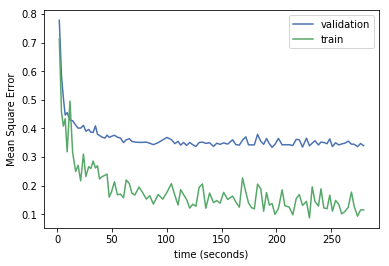

In [157]:
# Normalize the data
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

x_val -= mean
x_val /= std
# Data (Real; Imag) 4 layers (output layer without relu) , no dropout layers ADMA optimizer LR: 0.001 100epoch
model_location = "./DNN_AB4layers/model_demo.ckpt" 
train4(x_train,x_val, y_train,y_val, model_location, training_epochs=100,LR=0.001,n_hidden_1 = 200,n_hidden_2 = 80,n_hidden_3 = 80, batch_size=50)
train = sio.loadmat('./DNN_AB4layers/MSETime4Layer_%d_%d_%d'%(24, 50, 10))['train']
time = sio.loadmat('./DNN_AB4layers/MSETime4Layer_%d_%d_%d'%(24, 50, 10))['time']
val = sio.loadmat('./DNN_AB4layers/MSETime4Layer_%d_%d_%d'%(24, 50, 10))['validation']
plt.figure(0)
plt.plot(time.T, val.T,label='validation')
plt.plot(time.T, train.T,label='train')
plt.legend(loc='upper right')
plt.xlabel('time (seconds)')
plt.ylabel('Mean Square Error')
plt.savefig('MSE_train.eps', format='eps', dpi=1000)
plt.show()

train: 35000  validation: 15000 
epoch:0,  train:73.19%,  validation:82.79%.
epoch:10,  train:32.06%,  validation:36.88%.
epoch:20,  train:14.13%,  validation:33.36%.
epoch:30,  train:18.05%,  validation:33.37%.
epoch:40,  train:15.33%,  validation:33.54%.
epoch:50,  train:11.68%,  validation:33.50%.
epoch:60,  train:12.84%,  validation:32.26%.
epoch:70,  train:11.53%,  validation:32.45%.
epoch:80,  train:9.13%,  validation:31.51%.
epoch:90,  train:9.33%,  validation:32.16%.
training time: 228.75 s


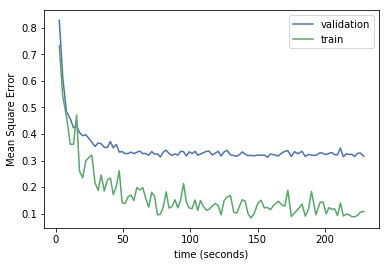

In [150]:
# Data (Real; Imag) 4 layers (output layer without relu) , no dropout layers ADMA optimizer LR: 0.001 100epoch
model_location = "./DNN_AB4layers/model_demo.ckpt" 
train4(x_train,x_val, y_train,y_val, model_location, training_epochs=100,LR=0.001,n_hidden_1 = 200,n_hidden_2 = 80,n_hidden_3 = 80, batch_size=50)
train = sio.loadmat('./DNN_AB4layers/MSETime4Layer_%d_%d_%d'%(24, 50, 10))['train']
time = sio.loadmat('./DNN_AB4layers/MSETime4Layer_%d_%d_%d'%(24, 50, 10))['time']
val = sio.loadmat('./DNN_AB4layers/MSETime4Layer_%d_%d_%d'%(24, 50, 10))['validation']
plt.figure(0)
plt.plot(time.T, val.T,label='validation')
plt.plot(time.T, train.T,label='train')
plt.legend(loc='upper right')
plt.xlabel('time (seconds)')
plt.ylabel('Mean Square Error')
plt.savefig('MSE_train.eps', format='eps', dpi=1000)
plt.show()

In [29]:
# Data (Real; Imag) 3 layers (output layer without relu) , no dropout layers ADMA optimizer LR: 0.001 500epoch
model_location = "./DNN_AB/model_demo.ckpt" 
train(x_train,x_val, y_train,y_val, model_location, training_epochs=500,LR=0.001, batch_size=200)
train = sio.loadmat('./DNN_AB/MSETimeLastLayer_%d_%d_%d'%(24, 200, 2))['train']
time = sio.loadmat('./DNN_AB/MSETimeLastLayer_%d_%d_%d'%(24, 200, 2))['time']
val = sio.loadmat('./DNN_AB/MSETimeLastLayer_%d_%d_%d'%(24, 200, 2))['validation']
plt.figure(0)
plt.plot(time.T, val.T,label='validation')
plt.plot(time.T, train.T,label='train')
plt.legend(loc='upper right')
plt.xlabel('time (seconds)')
plt.ylabel('Mean Square Error')
plt.savefig('MSE_train.eps', format='eps', dpi=1000)
plt.show()

train: 35000  validation: 15000 
epoch:0,  train:128.31%,  validation:128.96%.
epoch:50,  train:26.74%,  validation:33.80%.
epoch:100,  train:18.82%,  validation:30.93%.
epoch:150,  train:15.26%,  validation:30.07%.
epoch:200,  train:16.50%,  validation:29.51%.
epoch:250,  train:13.63%,  validation:29.20%.
epoch:300,  train:11.31%,  validation:29.34%.
epoch:350,  train:11.92%,  validation:29.37%.
epoch:400,  train:9.22%,  validation:29.19%.
epoch:450,  train:10.59%,  validation:29.51%.
training time: 485.63 s


FileNotFoundError: [Errno 2] No such file or directory: './DNN_AB/MSETimeLastLayer_24_200_2.mat'

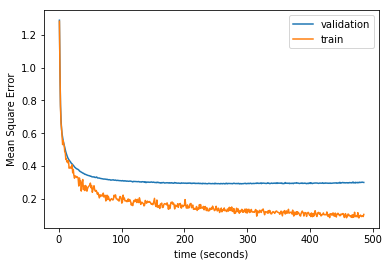

In [31]:
# Data (Real; Imag) 3 layers (output layer without relu) , no dropout layers ADMA optimizer LR: 0.001 500epoch
model_location = "./DNN_AB/model_demo.ckpt" 
train(x_train,x_val, y_train,y_val, model_location, training_epochs=500,LR=0.001, batch_size=200)
train = sio.loadmat('MSETimeLastLayer_%d_%d_%d'%(24, 200, 10))['train']
time = sio.loadmat('MSETimeLastLayer_%d_%d_%d'%(24, 200, 10))['time']
val = sio.loadmat('MSETimeLastLayer_%d_%d_%d'%(24, 200, 10))['validation']
plt.figure(0)
plt.plot(time.T, val.T,label='validation')
plt.plot(time.T, train.T,label='train')
plt.legend(loc='upper right')
plt.xlabel('time (seconds)')
plt.ylabel('Mean Square Error')
plt.savefig('MSE_train.eps', format='eps', dpi=1000)
plt.show()

# Test Performance

In [47]:
DateLocation='MIMO10000_3test.mat'
DataTest10000 = sio.loadmat(DateLocation)#load data
Xtest=DataTest10000['X']
Xtest = np.transpose(Xtest)
Ytest=DataTest10000['Y']
Ytest = np.transpose(Ytest)
Xtest = np.column_stack((np.real(Xtest), np.imag(Xtest)))
Ytest = np.column_stack((np.real(Ytest), np.imag(Ytest)))

In [33]:
X[1,:]

array([ 0.3457001 ,  0.73163844,  0.51398541, -0.21456514,  0.20779851,
       -0.55669301,  0.62819058, -0.81110105, -0.75580555, -0.57240202,
       -2.0819233 ,  1.01708846,  0.22994444, -0.53381493,  0.96894739,
       -1.21022487, -0.07229633, -0.17072884,  0.22571325,  0.22122444,
       -0.61156245, -0.02124948, -0.11658707,  0.44385608])

In [13]:

# Functions for deep neural network testing
def test(X, model_location, save_name, n_input, n_output, n_hidden_1 = 200, n_hidden_2 = 80, n_hidden_3 = 80, binary=0):
    tf.reset_default_graph()
    x = tf.placeholder("float", [None, n_input])
    is_train = tf.placeholder("bool")
    input_keep_prob = tf.placeholder(tf.float32)
    hidden_keep_prob = tf.placeholder(tf.float32)
    weights, biases = ini_weights(n_input, n_hidden_1, n_hidden_2, n_hidden_3, n_output)
    pred = multilayer_perceptron(x, weights, biases, input_keep_prob, hidden_keep_prob)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, model_location)
        start_time = time.time()
        y_pred = sess.run(pred, feed_dict={x: X, input_keep_prob: 1, hidden_keep_prob: 1, is_train: False})
        testtime = time.time() - start_time
        # print("testing time: %0.2f s" % testtime)
        if binary==1:
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
        sio.savemat(save_name, {'pred': y_pred})
    return y_pred



In [12]:
def DABtoComplex(XX, dim):
    size=XX.shape[1]
    X=np.empty( (XX.shape[0], dim), dtype= np.complex128 )
    X.real[:,:]=XX[:,0:dim]
    X.imag[:,:]=XX[:,dim:2*dim]
    return X

In [42]:
x=DABtoComplex(X,12)

In [44]:
x[1,:]

array([ 0.3457001 +0.22994444j,  0.73163844-0.53381493j,
        0.51398541+0.96894739j, -0.21456514-1.21022487j,
        0.20779851-0.07229633j, -0.55669301-0.17072884j,
        0.62819058+0.22571325j, -0.81110105+0.22122444j,
       -0.75580555-0.61156245j, -0.57240202-0.02124948j,
       -2.0819233 -0.11658707j,  1.01708846+0.44385608j])

In [43]:
X[1,:]

array([ 0.3457001 ,  0.73163844,  0.51398541, -0.21456514,  0.20779851,
       -0.55669301,  0.62819058, -0.81110105, -0.75580555, -0.57240202,
       -2.0819233 ,  1.01708846,  0.22994444, -0.53381493,  0.96894739,
       -1.21022487, -0.07229633, -0.17072884,  0.22571325,  0.22122444,
       -0.61156245, -0.02124948, -0.11658707,  0.44385608])

In [11]:
import time
def obj_sum_rate(xtest, y_pred,M,N,K, samples):
    # H ： sampels*12
    sum_rate=[]
    for i in range(samples):
        rate_nn=0
        H=np.reshape(xtest[i,:],[K,M,N])
        pnn=np.reshape(y_pred[i,:],[K,M,N])      
        for j in range(K):
            if j==i:
                rate_nn = rate_nn+np.real(np.log2(np.linalg.det(np.eye(M)+H[j,:,:] * pnn[j,:,:] * np.transpose(H[j,:,:]))))
            else:
                pnn[j,:,:]=pnn[j,:,:]+pnn[j-1,:,:]
                rate_nn = rate_nn+np.real(np.log2(np.linalg.det(np.eye(M)+H[j,:,:] * pnn[j,:,:] * np.transpose(H[j,:,:]))/np.linalg.det((np.eye(M)+H[j,:,:] * pnn[j-1,:,:] * np.transpose(H[j,:,:])))))
        sum_rate.append(rate_nn)
    return sum_rate



In [9]:
import time
model_location = "./DNN_AB/model_demo.ckpt"
save_name="./DNN_AB/Prediction_Dnn3_10000"

def CDF_Plot(sumRate1, sumRate2, label1= 'DNN', label2= 'IWF'):
    a = np.array(sumRate1) # your array of numbers
    num_bins1 = np.linspace(0, max(sumRate1), 50)
    counts1, bin_edges1 = np.histogram(a, bins='auto', normed=True)
    cdf1 = np.cumsum(counts1*np.diff(bin_edges1))

    b = np.array(sumRate2) # your array of numbers
    num_bins2 = np.linspace(0, max(sumRate2), 50)
    counts2, bin_edges2 = np.histogram(b, bins='auto', normed=True)
    cdf2 = np.cumsum(counts2*np.diff(bin_edges2))

#     plt.figure(1)
#     plt.subplot(221)
#     plt.title('CDF Analysis')
    # plt.xlim([0, 6])
    plt.xlabel('sum-rate')
    plt.plot(bin_edges1[1:], cdf1, color='black', label=label1)
    plt.plot(bin_edges2[1:],cdf2,color='red', label=label2)
    plt.legend()
    return 0

def histPlot(sumRate1,sumRate2, label=['DNN', 'IWF']):
#     plt.figure('%d'%K)
    plt.style.use('seaborn-deep')
    data = np.vstack([sumRate1, sumRate2]).T
    bins = np.linspace(0, max(sumRate2),50)
    plt.hist(data, bins, alpha=0.7, label=label)
#     plt.legend(loc='upper right')
#     plt.xlim([0, 5])
    plt.xlabel('sum-rate')
    plt.ylabel('number of samples')
    #     plt.savefig('Histogram_%d.eps'%K, format='eps', dpi=1000)
    plt.show()
    return 0
def performance(sumRate1,sumRate2, num):
# sumRate1, IWF; sumRate2, NN
    print('Sum-rate: IWF: %0.3f, DNN: %0.3f'%(sum(sumRate1)/num, sum(sumRate2)/num))
    print('Ratio: DNN: %0.3f%%\n' % (sum(sumRate2) / sum(sumRate1)* 100))
    return 0

def testPerformance(model_location, save_name, n_input, n_output,dim, M, N, K,samples):
    ypred=test(Xtest, model_location, save_name+'%s'%('test'), n_input,n_output, binary=0)
    trainPred=test(x_train, model_location, save_name+"%s"%('train'), n_input,n_output, binary=0)
    valPred=test(x_val, model_location, save_name+"%s"%('val'), n_input,n_output, binary=0)
    x=DABtoComplex(X,dim)
    xtest=DABtoComplex(Xtest,dim)
    ytest=DABtoComplex(Ytest,dim)
    ypred=DABtoComplex(ypred,dim)

    # train & val
    xtrain=DABtoComplex(x_train,dim)
    ytrain=DABtoComplex(y_train,dim)
    trainPred=DABtoComplex(trainPred,dim)
    xval=DABtoComplex(x_val,dim)
    yval=DABtoComplex(y_val,dim)
    valPred=DABtoComplex(valPred,dim)

    # test
    nnsumRate=obj_sum_rate(xtest, ypred, M, N, K, samples)
    IWFsumRate=obj_sum_rate(xtest, ytest, M, N, K, samples)
    #trian
    nnSRTrain=obj_sum_rate(xtrain, trainPred, M, N, K, samples)
    IWFSRTrain=obj_sum_rate(xtrain, ytrain, M, N, K, samples)
    # validation
    IWFSRVal=obj_sum_rate(xval, yval, M, N, K, samples)
    nnSRVal=obj_sum_rate(xval, valPred, M, N, K, samples)

    plt.figure(1)
    plt.subplot(311)
    plt.title('CDF AnalysisTest')
    CDF_Plot(nnsumRate,IWFsumRate, 'DNNTest', 'IWFTest')
    plt.subplot(312)
    plt.title('CDF Analysis_Train')
    CDF_Plot(nnSRTrain,IWFSRTrain, 'DNNTrain', 'IWFTrain')
    plt.subplot(313)
    plt.title('CDF Analysis_val')
    CDF_Plot(nnSRVal,IWFSRVal, 'DNNVal', 'IWFVal')
    
    plt.figure(2)
    plt.subplot(211)
    plt.title('Hist AnalysisTest')
    histPlot(nnsumRate,IWFsumRate, ['DNNTest', 'IWFTest'])
    plt.subplot(212)
    plt.title('Hist Analysis_Train')
    histPlot(nnSRTrain,IWFSRTrain, ['DNNTrain', 'IWFTrain'])
    
    performance(IWFsumRate, nnsumRate, samples)
    performance(IWFSRTrain, nnSRTrain, samples)
    return 0
    

INFO:tensorflow:Restoring parameters from ./DNN_AB4layers/model_demo.ckpt
INFO:tensorflow:Restoring parameters from ./DNN_AB4layers/model_demo.ckpt
INFO:tensorflow:Restoring parameters from ./DNN_AB4layers/model_demo.ckpt


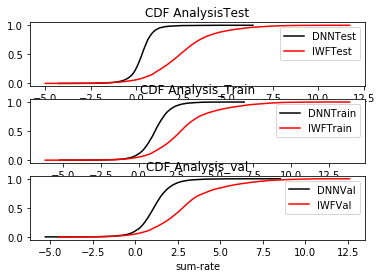

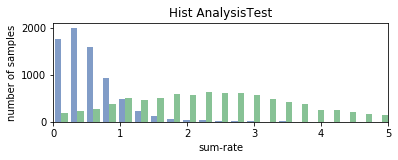

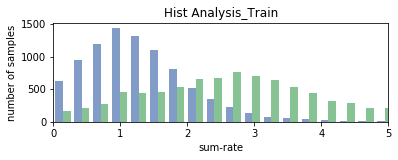

Sum-rate: IWF: 2.525, DNN: 0.296
Ratio: DNN: 11.705%

Sum-rate: IWF: 3.012, DNN: 1.081
Ratio: DNN: 35.902%



0

In [161]:
model_location = "./DNN_AB4layers/model_demo.ckpt" 
save_name="./DNN_AB4layers/Prediction_Dnn3_10000"
testPerformance(model_location, save_name, 24, 24,12, 2, 2, 3,10000)

In [119]:
ytestpre = sio.loadmat("./DNN_AB4layers/Prediction_Dnn3_10000test")['pred']

In [128]:
tf.square(ytestpre[1,:])

<tf.Tensor 'Square_3:0' shape=(24,) dtype=float32>

INFO:tensorflow:Restoring parameters from ./DNN_AB2/model_demo.ckpt
INFO:tensorflow:Restoring parameters from ./DNN_AB2/model_demo.ckpt
INFO:tensorflow:Restoring parameters from ./DNN_AB2/model_demo.ckpt


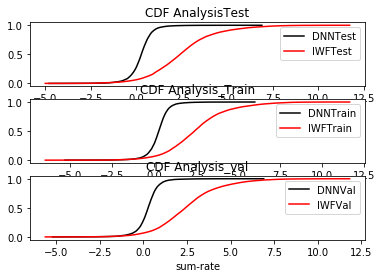

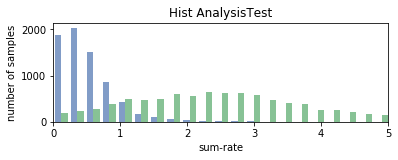

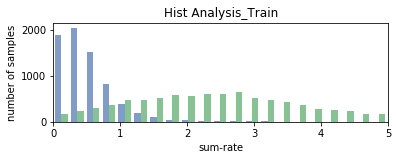

Sum-rate: IWF: 2.525, DNN: 0.257
Ratio: DNN: 10.177%

Sum-rate: IWF: 2.522, DNN: 0.246
Ratio: DNN: 9.742%



0

In [88]:
model_location = "./DNN_AB2/model_demo.ckpt"
save_name="./DNN_AB2/Prediction_Dnn3_10000"
testPerformance(model_location, save_name, 24, 24,12, 2, 2, 3,10000)

In [53]:
model_location = "./DNN_AB/model_demo.ckpt"
ypred=test(Xtest, model_location, "./DNN_AB/Prediction_Dnn3_10000", 24,24, binary=0)
trainPred=test(x_train, model_location, "./DNN_AB/Prediction_Dnn3_50000Tr", 24,24, binary=0)
valPred=test(x_val, model_location, "./DNN_AB/Prediction_Dnn3_50000Val", 24,24, binary=0)
D=12
x=DABtoComplex(X,12)
xtest=DABtoComplex(Xtest,12)
ytest=DABtoComplex(Ytest,12)
ypred=DABtoComplex(ypred,12)

# train & val
xtrain=DABtoComplex(x_train,12)
ytrain=DABtoComplex(y_train,12)
trainPred=DABtoComplex(trainPred,12)
xval=DABtoComplex(x_val,12)
yval=DABtoComplex(y_val,12)
valPred=DABtoComplex(valPred,12)

# test
nnsumRate=obj_sum_rate(xtest, ypred,2,2,3, 10000)
IWFsumRate=obj_sum_rate(xtest, ytest,2,2,3, 10000)
#trian
nnSRTrain=obj_sum_rate(xtrain, trainPred,2,2,3, 35000)
IWFSRTrain=obj_sum_rate(xtrain, ytrain,2,2,3, 35000)
# validation
IWFSRVal=obj_sum_rate(xval, yval,2,2,3, 15000)
nnSRVal=obj_sum_rate(xval, valPred,2,2,3, 15000)

print(len(nnsumRate))
print(len(IWFsumRate))

INFO:tensorflow:Restoring parameters from ./DNN_AB/model_demo.ckpt
INFO:tensorflow:Restoring parameters from ./DNN_AB/model_demo.ckpt
INFO:tensorflow:Restoring parameters from ./DNN_AB/model_demo.ckpt
10000
10000


0

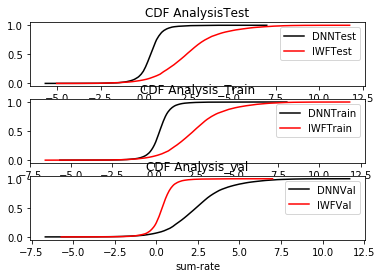

In [54]:
def CDF_Plot(sumRate1, sumRate2, label1= 'DNN', label2= 'IWF'):
    a = np.array(sumRate1) # your array of numbers
    num_bins1 = np.linspace(0, max(sumRate1), 50)
    counts1, bin_edges1 = np.histogram(a, bins='auto', normed=True)
    cdf1 = np.cumsum(counts1*np.diff(bin_edges1))

    b = np.array(sumRate2) # your array of numbers
    num_bins2 = np.linspace(0, max(sumRate2), 50)
    counts2, bin_edges2 = np.histogram(b, bins='auto', normed=True)
    cdf2 = np.cumsum(counts2*np.diff(bin_edges2))

#     plt.figure(1)
#     plt.subplot(221)
#     plt.title('CDF Analysis')
    # plt.xlim([0, 6])
    plt.xlabel('sum-rate')
    plt.plot(bin_edges1[1:], cdf1, color='black', label=label1)
    plt.plot(bin_edges2[1:],cdf2,color='red', label=label2)
    plt.legend()
    return 0
plt.figure(1)
plt.subplot(311)
plt.title('CDF AnalysisTest')
CDF_Plot(nnsumRate,IWFsumRate, 'DNNTest', 'IWFTest')
plt.subplot(312)
plt.title('CDF Analysis_Train')
CDF_Plot(nnSRTrain,IWFSRTrain, 'DNNTrain', 'IWFTrain')

# plt.subplot(313)
# plt.title('CDF Analysis_val')
# CDF_Plot(nnSRVal,IWFSRVal, 'DNNVal', 'IWFVal')



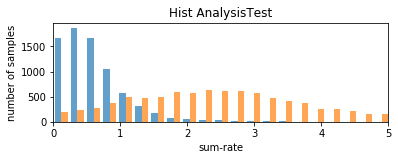

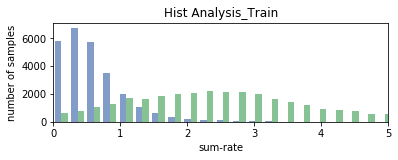

0

In [55]:
def histPlot(sumRate1,sumRate2, label=['DNN', 'IWF']):
#     plt.figure('%d'%K)
    plt.style.use('seaborn-deep')
    data = np.vstack([sumRate1, sumRate2]).T
    bins = np.linspace(0, max(sumRate2),50)
    plt.hist(data, bins, alpha=0.7, label=label)
#     plt.legend(loc='upper right')
    plt.xlim([0, 5])
    plt.xlabel('sum-rate')
    plt.ylabel('number of samples')
    #     plt.savefig('Histogram_%d.eps'%K, format='eps', dpi=1000)
    plt.show()
    return 0
plt.figure(2)
plt.subplot(211)
plt.title('Hist AnalysisTest')
histPlot(nnsumRate,IWFsumRate, ['DNNTest', 'IWFTest'])
plt.subplot(212)
plt.title('Hist Analysis_Train')
histPlot(nnSRTrain,IWFSRTrain, ['DNNTrain', 'IWFTrain'])



In [56]:
def performance(sumRate1,sumRate2, num):
# sumRate1, IWF; sumRate2, NN
    print('Sum-rate: IWF: %0.3f, DNN: %0.3f'%(sum(sumRate1)/num, sum(sumRate2)/num))
    print('Ratio: DNN: %0.3f%%\n' % (sum(sumRate2) / sum(sumRate1)* 100))
    return 0
performance(IWFsumRate, nnsumRate, 10000)
performance(IWFSRTrain, nnSRTrain, 35000)

Sum-rate: IWF: 2.525, DNN: 0.350
Ratio: DNN: 13.880%

Sum-rate: IWF: 2.517, DNN: 0.350
Ratio: DNN: 13.922%



0